# Ringed Seal Detector

This notebook has the final code used to create the ringed seal detector. 

## User Inputs

In [15]:
main_folder = r'C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test'
spec_file = main_folder + '\\' + 'spec_config_2sec.json'
data_folder = r'D:\ringed-seal-data'
db_name = main_folder + '\\' r'pierce_point_db.h5'


## Step One: Create Database 

A database consisting of manually verified spectrogram segments is created using excel workbooks.

In [26]:
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation

## Create Database ##

pp_pos = pd.read_excel(main_folder + '\\' + 'std_PP_positives.xlsx')
pp_pos2 = pp_pos.ffill()
pp_pos2 = sl.standardize(table=pp_pos2, start_labels_at_1=True)
print('Negatives standardized? ' + str(sl.is_standardized(pp_pos2)))

# join into a database

spec_cfg = load_audio_representation(spec_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=pp_pos2, data_dir=data_folder,
                    audio_repres=spec_cfg)

Negatives standardized? True


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 74.81it/s]

71 items saved to C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test\pierce_point_db.h5


In [25]:
import tables
tables.file._open_files.close_all()

Closing remaining open files:C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test\pierce_point_db.h5...done


## Step Three: Deploy Detector

### Copy Testing Files to Audio Folder

In [10]:
import shutil

pp_pos3 = pp_pos.ffill()

audio_folder = r'C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test\audio'

for idex, row in pp_pos3.iterrows():
    shutil.copyfile(pp_pos3.loc[idex]['filename'], audio_folder + '\\' + pp_pos3.loc[idex]['filename'].split('\\')[-1])

print('done')

done


### Deploy Detector on Audio Data

In [27]:
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold
import numpy as np
import tensorflow as tf
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface

temp_folder = main_folder + '\\' + 'ringedS_tmp_folder'
detections_csv = main_folder + '\\' + 'detections_raw.csv'
threshold = 0.5
step_size = 2.0
batch_size = 16
buffer = 0.5 
output_name = main_folder + '\\' + 'rs-2sec.kt'

model = ResNetInterface.load(model_file=output_name, new_model_folder=temp_folder)

audio_repr = load_audio_representation(path=spec_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    # What do these labels represent? Is it 0 for no, and 1 for yes? why is 0 included in the
    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:20<00:00,  7.37it/s]


## Compare Results

In [9]:
#annotations = pd.read_excel(r'C:\Users\kzammit\Documents\Detector\manual_detector_2sec\sel_test_pos.xlsx')
#annotations = annotations.ffill()
#detections = pd.read_csv(r'C:\Users\kzammit\Documents\Detector\manual_detector_2sec\detections_raw.csv')

#detected_list = []

#for idx, row in annotations.iterrows():  # loop over annotations
#    filename_annot = row['filename'].split("\\")[-1]
#    time_annot_start = row['start']
#    time_annot_end = row['end']
#    detected = False
#    for _, d in detections.iterrows():  # loop over detections
#        filename_det = d['filename']
#        start_det = d['start']
#        end_det = start_det + d['end']
        # if the filenames match and the annotated time falls with the start and
        # end time of the detection interval, consider the call detected
#        if filename_annot == filename_det and time_annot_start >= start_det and time_annot_end <= end_det:
#            detected = True
#            break

#    detected_list.append(detected)

#annotations['detected'] = detected_list  # add column to the annotations table

#annotations.to_excel('detected_annots.xlsx')

done


In [17]:
def compute_detections(labels, scores, threshold=0.5):
    """

    :param labels:
    :param scores:
    :param threshold:
    :return:
    """
    predictions = np.where(scores >= threshold, 1,0)

    TP = tf.math.count_nonzero(predictions * labels).numpy()
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [30]:
from ketos.data_handling.data_feeding import JointBatchGen

import os 
import csv

output_dir = main_folder + '\\' + 'metrics'

db = dbi.open_file(db_name, 'r')

# Load the trained model
model = ResNetInterface.load(output_name, load_audio_repr=False, new_model_folder=temp_folder)

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

# Convert the data to the correct format for the model, and generate batches of data
gens = []

# not sure?
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset
for group in db.walk_nodes(table, "Table"):
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # attach the batches together so there's one for each dataset
    gens.append(generator)

gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

scores = []
labels = []

for batch_id in range(gen.n_batches):
    hdf5_ids, batch_X, batch_Y = next(gen)

    batch_labels = np.argmax(batch_Y, axis=1)

    # will return the scores for just one class (with label 1)
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    scores.extend(batch_scores)
    labels.extend(batch_labels)

labels = np.array(labels)
scores = np.array(scores)

print('Length of labels is ' + str(len(labels)))

predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

print(f'\nSaving detections output to {output_dir}/')

df_group = pd.DataFrame()
for group in db.walk_nodes(table, "Table"):
    df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
    df_group = pd.concat([df_group, df], ignore_index=True)
df_group['label'] = labels[:]
df_group['predicted'] = predicted[:]
df_group['score'] = scores[:]
df_group.to_csv(os.path.join(os.getcwd(), output_dir, "classifications.csv"), mode='w', index=False)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
FPP = FP / (TN + FP)
confusion_matrix = [[TP, FN], [FP, TN]]
print(f'\nPrecision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('\nConfusionMatrix:')
print('\n[TP, FN]')
print('[FP, TN]')
print(f'{confusion_matrix[0]}')
print(f'{confusion_matrix[1]}')

print(f"\nSaving metrics to {output_dir}/")

# Saving precision recall and F1 Score for the defined thrshold
metrics = {'Precision': [precision], 'Recall': [recall], "F1 Score": [f1]}
metrics_df = pd.DataFrame(data=metrics)

metrics_df.to_csv(os.path.join(os.getcwd(), output_dir, "metrics.csv"), mode='w', index=False)

# Appending a confusion matrix to the file
row1 = ["Confusion Matrix", "Predicted"]
row2 = ["Actual", "RS", "Background Noise"]
row3 = ["RS", TP, FN]
row4 = ["Background Noise", FP, TN]
with open(os.path.join(os.getcwd(), output_dir, "metrics.csv"), 'a', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow([])
    writer.writerow(row1)
    writer.writerow(row2)
    writer.writerow(row3)
    writer.writerow(row4)

db.close()

Length of labels is 284

Saving detections output to C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test\metrics/

Precision: 0.25
Recall: 0.9014084507042254
F1 Score: 0.3914373088685015

ConfusionMatrix:

[TP, FN]
[FP, TN]
[64, 7]
[192, 21]

Saving metrics to C:\Users\kzammit\Documents\Detector\manual_detector_2sec\pp-test\metrics/


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('no title')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

no title


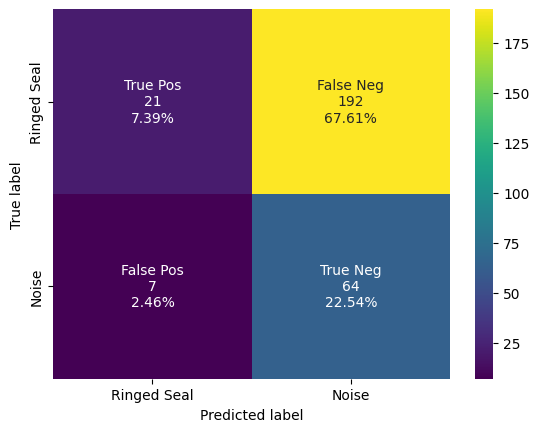

In [38]:
from sklearn.metrics import confusion_matrix

classifications_file = output_dir + '\\' + 'classifications.csv'

classifications = pd.read_csv(classifications_file)

cm = confusion_matrix(classifications['label'], classifications['predicted'])

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

#confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories,
#                 cmap=sns.diverging_palette(20, 220, as_cmap=True))

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories,
                 cmap='viridis')